### Accuracy vs DieSize

In [1]:
!pip install pickle5

In [2]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses, optimizers, regularizers, callbacks

import os
import time
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

import cv2
from scipy.ndimage import median_filter
from skimage.transform import resize as sk_resize
from skimage.util import img_as_ubyte
from skimage.morphology import skeletonize, thin

import helpers as helper
from keras_model_s3_wrapper import *

import boto3
import pickle5 as pickle
s3 = boto3.resource('s3')
bucket_name = 'wafer-capstone'
my_bucket = s3.Bucket(bucket_name)

In [3]:
# specify variables

# specify data to load
path = 'data'
filename = 'WM-clean'

data_key = f'{path}/{filename}.pkl'
raw_data = pickle.loads(my_bucket.Object(data_key).get()['Body'].read())

# add index column to identify specific wafers 
raw_data.reset_index(inplace=True)
raw_data = raw_data.rename(columns={'index':'ID'})

# keep only test set
data = raw_data[raw_data.dataset == 'test'].reset_index(drop=True)

# add detection model labels
data['detectLabels'] = data['failureType'].apply(lambda x: 0 if x == 'none' else 1)

# add classification model labels
fail_dict = {'none': 8, 'Loc': 0, 'Edge-Loc': 1, 'Center': 2, 'Edge-Ring': 3, 
             'Scratch': 4, 'Random': 5, 'Near-full': 6, 'Donut': 7}
data['classifyLabels'] = data['failureType'].apply(lambda x: fail_dict[x])

print(data.shape)
data.head()

(25943, 14)


,ID,waferMap,dieSize,lotName,waferIndex,failureType,encoding,x_,y_,shape,labels,dataset,detectLabels,classifyLabels
0,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,0,8
1,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,0,8
2,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,6.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,0,8
3,10,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,11.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,0,8
4,11,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,12.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,0,8


In [4]:
# load predictions
predictions_path = '../results/yutandem-224-thin2.pkl'
with open(predictions_path, "rb") as fh:
    predictions = pickle.load(fh)

# unpack predictions
defect_ids = predictions[0]
detect_probs = predictions[1]
classify_probs = predictions[2]
labels = predictions[3]

# probabilities for the highest class for each model
detect_max_prob = [max(x) for x in detect_probs]
classify_max_prob = [max(x) for x in classify_probs]

# second highest class for defective sample
classify_label2 = [x.argsort()[-2] for x in classify_probs]

# second highest class probability
classify_max_prob2 = [x[i] for x, i in zip(classify_probs, classify_label2)]

# add columns to dataframe
data['pred_labels'] = labels

# add column of probabilities predicted class 
def add_max_prob(row):
    i = row.name
    if row['pred_labels'] == 8:
        return detect_max_prob[i] * 100
    else:
        j = defect_ids.index(data.ID[i])
        return (detect_max_prob[i] * classify_max_prob[j]) * 100

data['pred_prob'] = data.apply(lambda row: add_max_prob(row), axis=1)

print(data.shape)
data.head()

(25943, 16)


,ID,waferMap,dieSize,lotName,waferIndex,failureType,encoding,x_,y_,shape,labels,dataset,detectLabels,classifyLabels,pred_labels,pred_prob
0,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,0,8,8,99.999452
1,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,0,8,8,99.999988
2,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,6.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,0,8,8,99.999964
3,10,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,11.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,0,8,8,99.999988
4,11,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,12.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,0,8,8,99.987590


In [5]:
# add column indicating if prediction is correct
def correct_bool(row):
    if row['pred_labels'] == row['classifyLabels']:
        return 1
    else:
        return 0
    
data['correct'] = data.apply(lambda row: correct_bool(row), axis=1)
data.head()

,ID,waferMap,dieSize,lotName,waferIndex,failureType,encoding,x_,y_,shape,labels,dataset,detectLabels,classifyLabels,pred_labels,pred_prob,correct
0,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,0,8,8,99.999452,1
1,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,0,8,8,99.999988,1
2,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,6.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,0,8,8,99.999964,1
3,10,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,11.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,0,8,8,99.999988,1
4,11,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,12.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,0,8,8,99.987590,1


In [11]:
dieSizes = data.dieSize.unique()

# collect accuracy for each dieSize
accuracies = []
for size in dieSizes:
    correct = len([i for i in range(len(data)) if (data.dieSize[i] == size and data.correct[i] == 1)])
    total = len(data.groupby('dieSize').get_group(size))
    accuracies.append(correct/total*100)

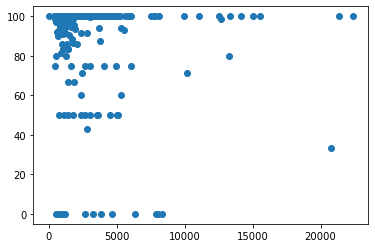

In [12]:
plt.scatter(dieSizes, accuracies)